This notebook will quickly walk you through the new features related to scattering and aerosols.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nemesispy.common.info_mol_id import mol_id
from nemesispy.common.constants import *
import os
from nemesispy.radtran.forward_model import ForwardModel
import spectres

In [2]:
# read from prf
prf_header = ['height', 'press', 'temp', 'h2o', 'co2', 'co', 'ch4', 'h2', 'he', 'na', 'k']
prf = pd.read_csv('./example_data/hd189.prf', skiprows=11, header=None, sep='\s+')
prf.columns = prf_header
print(prf.head())
H_model = prf['height'].values * 1e3
P_model = prf['press'].values * ATM
T_model = prf['temp'].values
VMR_model = prf[['h2o', 'co2', 'co', 'ch4','na','k', 'h2', 'he']].values

     height  press    temp     h2o     co2      co     ch4     h2      he  \
0     0.000  25.00  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
1   297.764  15.00  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
2   549.673   9.87  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
3   785.191   7.16  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
4  1011.136   5.47  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   

         na             k  
0  0.000005  1.000000e-07  
1  0.000005  1.000000e-07  
2  0.000005  1.000000e-07  
3  0.000005  1.000000e-07  
4  0.000005  1.000000e-07  


[0.043 0.048 0.043 0.043 0.045]


<ErrorbarContainer object of 3 artists>

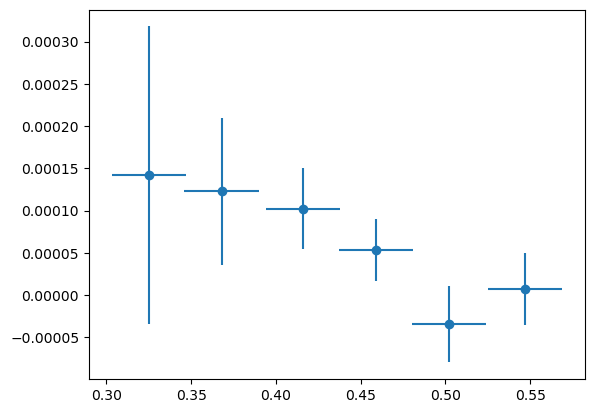

In [3]:
# planet reflected spectrum
planet_spec = pd.read_csv('./example_data/hd189_data.txt', header=None, sep='\s+')
planet_wave = planet_spec[0].values
planet_flux = planet_spec[1].values
planet_err = planet_spec[2].values
print(np.diff(planet_wave))
plt.errorbar(planet_wave, planet_flux, yerr=planet_err, xerr=0.022, fmt='o')

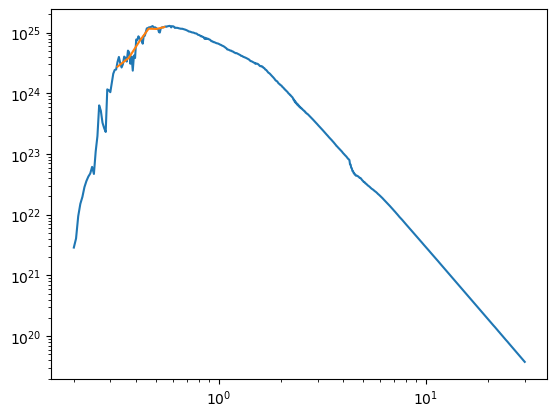

In [4]:
# stellar spectrum
st_spec = pd.read_csv('./example_data/hd189.dat', skiprows=3, header=None, sep='\s+')
st_wave_full = st_spec[0].values
st_flux_full = st_spec[1].values / (4*np.pi)
st_wave = planet_wave.copy()
st_flux = spectres.spectres(planet_wave, st_wave_full, st_flux_full)
plt.loglog(st_wave_full, st_flux_full)
plt.loglog(st_wave, st_flux)
# plt.gca().set_xscale('log')

In [5]:
# enstatite
enstatite = pd.read_csv('./example_data/enstatite.dat', skiprows=2, header=None, sep='\s+')
en_wave = enstatite[0].values
en_real = enstatite[1].values
en_imag = enstatite[2].values

In [6]:
# Wavelengths grid for the spectrum (microns)
wave_grid = planet_wave
nwave = len(wave_grid)
# Orbital phase grid (degree)
phase_grid = np.array([ 22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
    202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5])
nphase = len(phase_grid)
# Pick resolution for the disc average
nmu = 5 # Number of mu bins
# Reference planetary parameters
M_plt = 2167.664 * 1e24
R_plt = 84592.31 * 1e3 # m
# List of gas species to include in the model using identifiers
gas_names_active = ['H2O', 'CO2', 'CO', 'CH4','Na','K']
nvmr = len(gas_names_active)
# Spectrally inactive gases to include
gas_names_inactive = ['H2', 'He']
gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id) # Isotopologue identifier
lowres_file_paths = [f'{gas}_hd189_refl.kta' for gas in gas_names_active]
# __location__ = os.environ['nemesispy_scatter']
__location__ = '.'
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')
# Define the atmospheric model
NLAYER = len(P_model) # Number of layers

In [7]:
    # Create a ForwardModel object
FM = ForwardModel()
FM.set_planet_model(
    M_plt=M_plt,R_plt=R_plt,
    gas_id_list=gas_id,iso_id_list=iso_id,
    NLAYER=NLAYER
    )
FM.set_opacity_data(
    kta_file_paths=lowres_file_paths,
    cia_file_path=cia_file_path
)
print(lowres_file_paths)

['./nemesispy/data/ktables/H2O_hd189_refl.kta', './nemesispy/data/ktables/CO2_hd189_refl.kta', './nemesispy/data/ktables/CO_hd189_refl.kta', './nemesispy/data/ktables/CH4_hd189_refl.kta', './nemesispy/data/ktables/Na_hd189_refl.kta', './nemesispy/data/ktables/K_hd189_refl.kta']


Now we can add modes. Makephase might take a few seconds to compile.

In [8]:
FM.clear_phase_function()
# Using 20 calculation wavelengths for Makephase,
# evenly distributed over our wavelength range
NWAVE_NIMAG = len(en_wave)
n_imag_wave_grid = en_wave

n_imag =  en_imag
# n_real is set by reference for now
n_real = en_real

# Adding mode - constant sized particles (iscat=4)

FM.add_phase_function(mean_size = 0.1, 
                      size_variance = 0.3, 
                      n_imag = n_imag, 
                      n_imag_wave_grid = n_imag_wave_grid, 
                      n_real_reference = n_real,
                      n_real_reference_wave= 0.4,
                      iscat = 4)

We can have a look at the properties of our different aerosol modes.

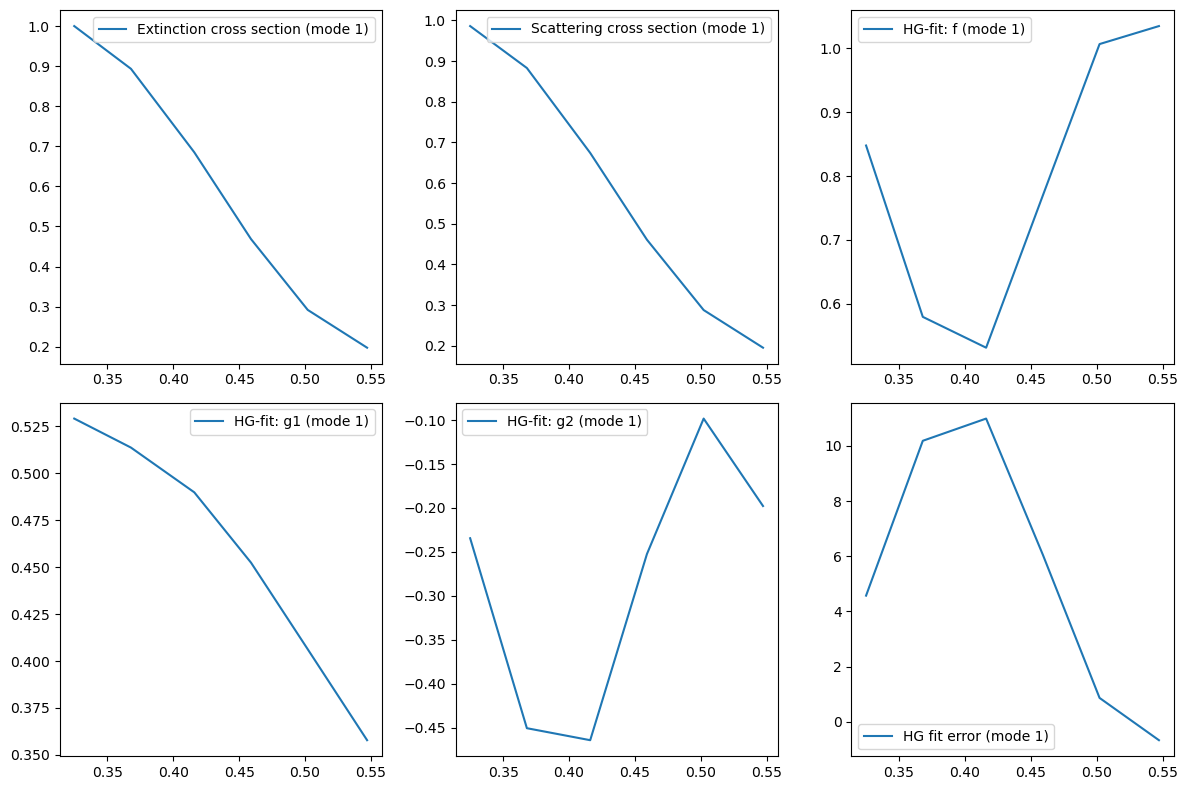

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
parameters = ['Extinction cross section','Scattering cross section',
              'HG-fit: f','HG-fit: g1','HG-fit: g2','HG fit error']
for i in range(6):
    row = i // 3
    col = i % 3
    axs[row, col].plot(FM.wave_grid, FM.phase_func[:, :, i].transpose())
    axs[row, col].legend([f'{parameters[i]} (mode 1)', f'{parameters[i]} (mode 2)'])

plt.tight_layout()
plt.show()

We can also calculate point spectra as well as disc spectra. You can see the effect of our second aerosol mode very clearly between 1um and 1.5um in this case.

In [10]:
from time import time
FM.clear_phase_function()
FM.add_phase_function(mean_size = 0.1, 
                      size_variance = 0.3, 
                      n_imag = n_imag, 
                      n_imag_wave_grid = n_imag_wave_grid, 
                      n_real_reference = n_real,
                      n_real_reference_wave= 0.4,
                      iscat = 1)

toc = time()
point = FM.calc_point_spectrum_hydro(P_model = P_model, 
                                     T_model = T_model, 
                                     VMR_model = VMR_model, 
                                     angles=np.array([0.0,0.0,180.0]),
                                     solspec=st_flux) # angles: stellar, emission, azimuth
tic = time()
print(f'Ran in {tic-toc}s')

# Constant aerosol 
A_model = 2e-2 * np.ones((NLAYER, 1))

toc = time()
point_aerosol = FM.calc_point_spectrum_hydro(P_model = P_model, 
                                     T_model = T_model, 
                                     VMR_model = VMR_model, 
                                     A_model = A_model,
                                     angles=np.array([0.0,0.0,180.0]),
                                     solspec=st_flux) # angles: stellar, emission, azimuth
tic = time()
print(f'Scattering ran in {tic-toc}s')

/home/p/penn/jupyter/nemesispy_agni/nemesispy/radtran/calc_radiance.py:677: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  spec_w_g[:,ig] = calc_spectrum_scloud11(wave_grid, phase_func,radground,solspec,


Ran in 55.28401708602905s
Scattering ran in 2.54351544380188s


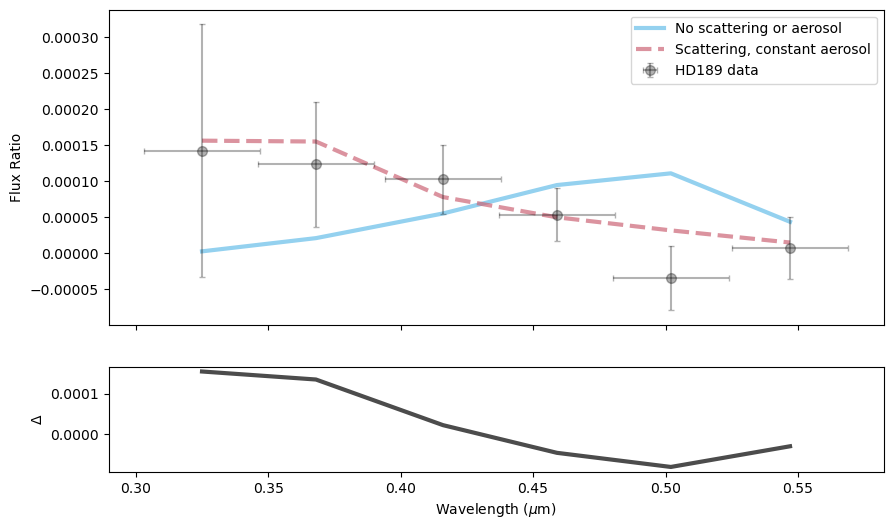

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3, 1], sharex=True)
ax1.plot(wave_grid, point, label='No scattering or aerosol', color='#88CCEE', lw=3, alpha=0.9)
ax1.plot(wave_grid, point_aerosol, label='Scattering, constant aerosol', color='#CC6677', lw=3, alpha=0.7, linestyle='--')
ax1.errorbar(wave_grid, planet_flux, yerr=planet_err, xerr=0.022, fmt='o', color='k', \
            ms=7, elinewidth=1.5, capsize=2, label='HD189 data', alpha=0.3)
ax1.set_ylabel('Flux Ratio')
ax1.legend()
ax2.plot(wave_grid, (point_aerosol - point), color='k', lw=3, alpha=0.7)
ax2.set_ylabel('$\Delta$')
plt.xlabel('Wavelength ($\mu$m)')
plt.savefig('HD189.png', dpi=600)